In [1]:
!pip install gdown
!gdown --id 1LDStOGuPFQRyl0jug70sNzqyrNJRDBx_
!gdown --id 1X5Ek5mQYjNkw8k87gt_VCFDhPCSwXbmF

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1LDStOGuPFQRyl0jug70sNzqyrNJRDBx_
From (redirected): https://drive.google.com/uc?id=1LDStOGuPFQRyl0jug70sNzqyrNJRDBx_&confirm=t&uuid=e46aeb54-d7c1-4bb3-9f90-b9c7207b55d6
To: /kaggle/working/3D-IR-MAH-CT.zip
100%|██████████████████████████████████████| 2.73G/2.73G [00:37<00:00, 72.2MB/s]
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1X5Ek5mQYjNkw8k87gt_VCFDhPCSwXbmF
From (redirected): https://drive.google.com/uc?id=1X5Ek5mQYjNkw8k87gt_VCFDhPCSwXbmF&confirm=t&uuid=6cf0b

In [ ]:
!unzip '/kaggle/working/NL3DTIF.zip' -d '/kaggle/working/'
!unzip '/kaggle/working/3D-IR-MAH-CT.zip' -d '/kaggle/working/'

In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy import ndimage

In [4]:
print("Num CPU(s) Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPU(s) Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPU(s) Available:  1
Num GPU(s) Available:  1


In [5]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, width_factor, height_factor, 1))
    return img






def plot_slices(num_rows, num_cols, data):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    
    n = len(data)
  
    for i in range(num_rows * num_cols):
        if i < n:
            # Adds a subplot at the 1st position
            fig.add_subplot(num_rows, num_cols, i+1)

            # showing image
            plt.imshow(data[i])
            plt.axis('off')
            
            
      
    
    
def prepare_3D_samples(main_dir, inp_lst):
    
    final_lst = []
    for i in tqdm(inp_lst):
        tmp_dir = os.path.join(main_dir,i)
        tmp_lst = os.listdir(tmp_dir)
        tmp_lst.sort()
        
        tmp_3d = []
        for j in tmp_lst:
            tmp_3d.append(plt.imread(os.path.join(main_dir,i,j)))
        
        
        final_lst.append(resize_volume(np.array(tmp_3d)))
    
    return np.array(final_lst)




def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 0, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        return volume
    
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


In [6]:
cov_main_dir = '/kaggle/working/covid_3D'
norm_main_dir = '/kaggle/working/NL3DTIF'

cov_lst = os.listdir(cov_main_dir)
cov_lst.sort()
random.Random(1).shuffle(cov_lst)

norm_lst = os.listdir(norm_main_dir)
norm_lst.sort()
random.Random(1).shuffle(norm_lst)

print(len(cov_lst))
print(cov_lst[:5])
print(len(norm_lst))
print(norm_lst[:5])
print('_________')

covid_volume = prepare_3D_samples(cov_main_dir, cov_lst)
normal_volume = prepare_3D_samples(norm_main_dir, norm_lst)
print('_________')

print('covid_volume:', np.shape(covid_volume))
print('normal_volume:', np.shape(normal_volume))

133
['77', '84', '65', '61', '97']
76
['020', '067', '003', '057', '012']
_________


100%|██████████| 76/76 [34:52<00:00, 27.53s/it]


_________
covid_volume: (133, 128, 128, 128, 3)
normal_volume: (76, 128, 128, 128, 3)


In [7]:
normal_labels = np.array([1 for _ in range(len(normal_volume))])
covid_labels = np.array([0 for _ in range(len(covid_volume))])

In [8]:
x_train = np.concatenate((covid_volume[:107], normal_volume[:61]), axis=0)
y_train = np.concatenate((covid_labels[:107], normal_labels[:61]), axis=0)

x_valid = np.concatenate((covid_volume[107:120], normal_volume[61:68]), axis=0)
y_valid = np.concatenate((covid_labels[107:120], normal_labels[61:68]), axis=0)

x_test = np.concatenate((covid_volume[120:], normal_volume[68:]), axis=0)
y_test = np.concatenate((covid_labels[120:], normal_labels[68:]), axis=0)

In [9]:
print('x_train:', np.shape(x_train))
print('y_train:', np.shape(y_train))
print('x_valid:', np.shape(x_valid))
print('y_valid:', np.shape(y_valid))
print('x_test:', np.shape(x_test))
print('y_test:', np.shape(y_test))


x_train: (168, 128, 128, 128, 3)
y_train: (168,)
x_valid: (20, 128, 128, 128, 3)
y_valid: (20,)
x_test: (21, 128, 128, 128, 3)
y_test: (21,)


label: 0
label 1 is normal and label 0 is covid 19


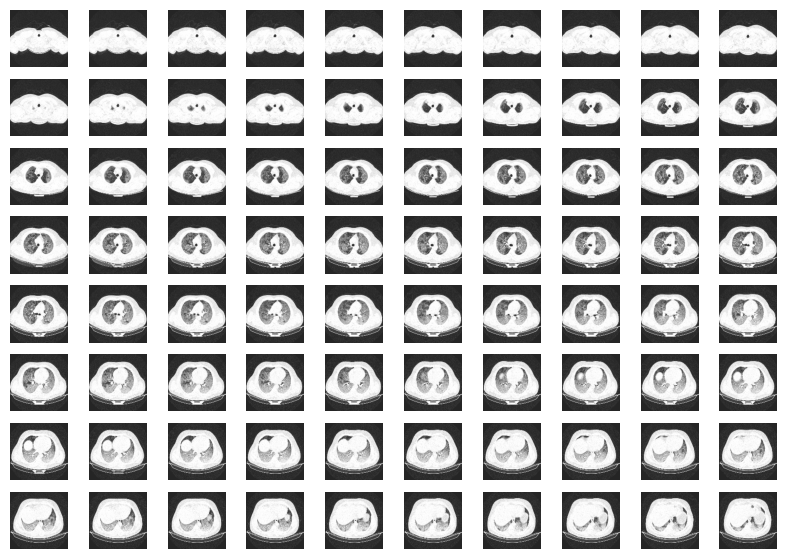

In [10]:
# visualize a sample in x_train

print('label:',y_train[0])
print('label 1 is normal and label 0 is covid 19')

plot_slices(8,10,x_train[0])

In [11]:
def train_preprocessing(volume, label):
    # rescaling
    volume = tf.cast(volume, tf.float32) / 255.0
    # Rotate volume
    volume = rotate(volume)
    return volume, label


def validation_preprocessing(volume, label):
    # rescaling
    volume = tf.cast(volume, tf.float32) / 255.0
    return volume, label

In [12]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 4

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

# Only rescale.
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

# 3D-AlexNet

In [14]:
AlexNet_3d = tf.keras.models.Sequential([
    tf.keras.layers.Conv3D(filters = 96, kernel_size = (11,11,11), strides = 4, padding= 'valid', activation = 'relu',
                           input_shape= [128,128,128,3]),
    tf.keras.layers.MaxPooling3D((3,3,3), strides=2, padding = 'valid'),
    tf.keras.layers.Conv3D(filters = 256, kernel_size = (5,5,5), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling3D((3,3,3), strides=2, padding = 'valid'),
    tf.keras.layers.Conv3D(filters = 384, kernel_size = (3,3,3), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv3D(filters = 384, kernel_size = (3,3,3), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv3D(filters = 256, kernel_size = (3,3,3), strides = 1, padding = 'same', activation = 'relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
AlexNet_3d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 30, 30, 96)    383424    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 14, 14, 96)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 14, 14, 256)   3072256   
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 6, 6, 256)     0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 6, 6, 384)      2654592   
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 6, 6, 384)      3

# Optimum LR

In [16]:
# finding appropreate learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10 ** (epoch/20)
)

AlexNet_3d.compile(optimizer='adam' , loss='binary_crossentropy')

In [17]:
history = AlexNet_3d.fit(train_dataset,
                    validation_data = validation_dataset,
                    callbacks=[lr_schedule],
                    epochs = 100,
                    verbose = 1)

Epoch 1/100
42/42 [==============================] - 158s 3s/step - loss: 0.6972 - val_loss: 0.6945 - lr: 1.0000e-08
Epoch 2/100
42/42 [==============================] - 154s 4s/step - loss: 0.6901 - val_loss: 0.6927 - lr: 1.1220e-08
Epoch 3/100
42/42 [==============================] - 155s 4s/step - loss: 0.6959 - val_loss: 0.6910 - lr: 1.2589e-08
Epoch 4/100
42/42 [==============================] - 151s 4s/step - loss: 0.6891 - val_loss: 0.6892 - lr: 1.4125e-08
Epoch 5/100
42/42 [==============================] - 151s 4s/step - loss: 0.6893 - val_loss: 0.6868 - lr: 1.5849e-08
Epoch 6/100
42/42 [==============================] - 150s 4s/step - loss: 0.6870 - val_loss: 0.6846 - lr: 1.7783e-08
Epoch 7/100
42/42 [==============================] - 152s 4s/step - loss: 0.6844 - val_loss: 0.6822 - lr: 1.9953e-08
Epoch 8/100
42/42 [==============================] - 151s 4s/step - loss: 0.6849 - val_loss: 0.6793 - lr: 2.2387e-08
Epoch 9/100
42/42 [==============================] - 155s 4s/ste

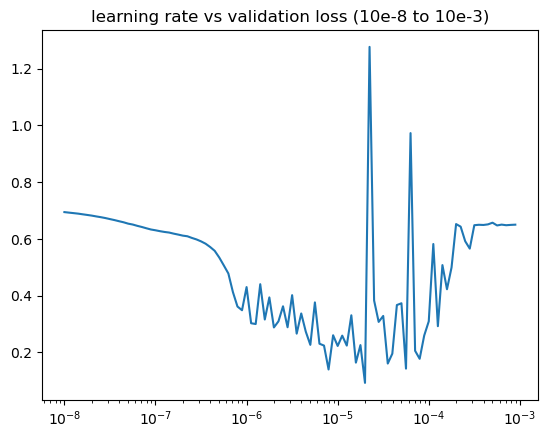

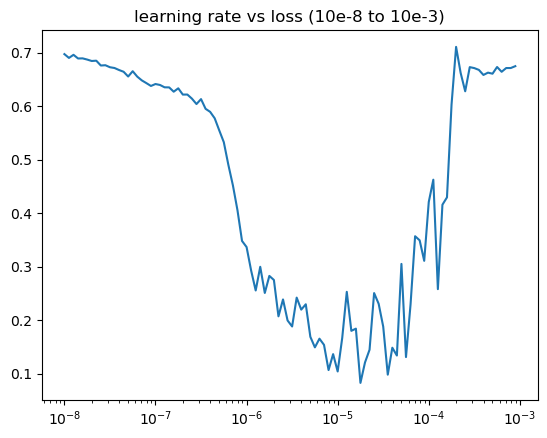

<Figure size 640x480 with 0 Axes>

In [18]:
#plot learning rate schedule

lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs , history.history['val_loss'])
plt.title('learning rate vs validation loss (10e-8 to 10e-3)')
plt.figure()
plt.semilogx(lrs , history.history['loss'])
plt.title('learning rate vs loss (10e-8 to 10e-3)')
plt.figure()

plt.show()

# Training Process

In [13]:
AlexNet_3d = tf.keras.models.Sequential([
    tf.keras.layers.Conv3D(filters = 96, kernel_size = (11,11,11), strides = 4, padding= 'valid', activation = 'relu',
                           input_shape= [128,128,128,3]),
    tf.keras.layers.MaxPooling3D((3,3,3), strides=2, padding = 'valid'),
    tf.keras.layers.Conv3D(filters = 256, kernel_size = (5,5,5), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling3D((3,3,3), strides=2, padding = 'valid'),
    tf.keras.layers.Conv3D(filters = 384, kernel_size = (3,3,3), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv3D(filters = 384, kernel_size = (3,3,3), strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv3D(filters = 256, kernel_size = (3,3,3), strides = 1, padding = 'same', activation = 'relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

AlexNet_3d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 30, 30, 96)    383424    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 14, 14, 96)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 14, 14, 256)   3072256   
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 6, 6, 256)     0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 6, 6, 384)      2654592   
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 6, 6, 384)      3

In [14]:
AlexNet_3d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-7),
                   loss='binary_crossentropy', metrics = ['acc'])

In [15]:
history = AlexNet_3d.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 50,
                    verbose = 1)

Epoch 1/50
42/42 [==============================] - 157s 3s/step - loss: 0.6522 - acc: 0.6488 - val_loss: 0.6348 - val_acc: 0.6500
Epoch 2/50
42/42 [==============================] - 152s 4s/step - loss: 0.6379 - acc: 0.6369 - val_loss: 0.6212 - val_acc: 0.6500
Epoch 3/50
42/42 [==============================] - 150s 4s/step - loss: 0.6300 - acc: 0.6369 - val_loss: 0.6133 - val_acc: 0.6500
Epoch 4/50
42/42 [==============================] - 152s 4s/step - loss: 0.6270 - acc: 0.6369 - val_loss: 0.6051 - val_acc: 0.6500
Epoch 5/50
42/42 [==============================] - 152s 4s/step - loss: 0.6095 - acc: 0.6369 - val_loss: 0.5963 - val_acc: 0.6500
Epoch 6/50
42/42 [==============================] - 154s 4s/step - loss: 0.6011 - acc: 0.6369 - val_loss: 0.5853 - val_acc: 0.6500
Epoch 7/50
42/42 [==============================] - 150s 4s/step - loss: 0.5921 - acc: 0.6369 - val_loss: 0.5747 - val_acc: 0.6500
Epoch 8/50
42/42 [==============================] - 149s 4s/step - loss: 0.5782 - a

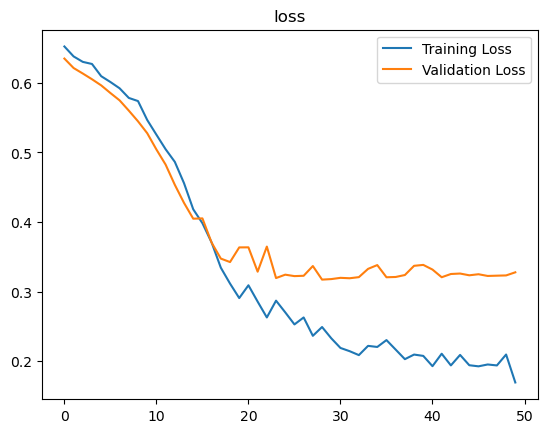

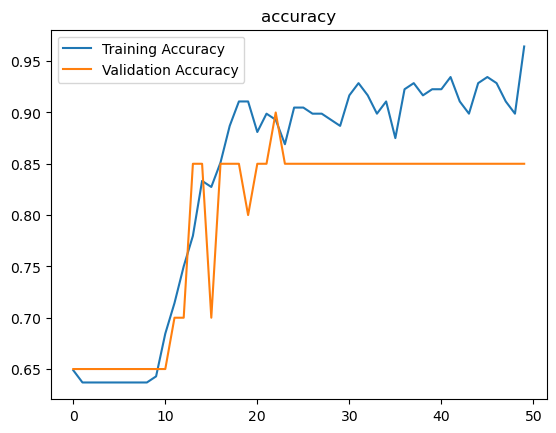

In [16]:
#plot acc and loss

AlexNet_3d.save('/kaggle/working/AlexNet_3d.h5')

epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['loss'], label='Training Loss')
plt.plot(epochs , history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.legend()

plt.figure()

plt.plot(epochs , history.history['acc'], label='Training Accuracy')
plt.plot(epochs , history.history['val_acc'], label='Validation Accuracy')
plt.title('accuracy')
plt.legend()

plt.show()

# Statistics

In [18]:
AlexNet_3d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7) , 
                loss='binary_crossentropy', metrics = ['acc',
                                                      tf.keras.metrics.AUC(),
                                                      tf.keras.metrics.Precision(),
                                                      tf.keras.metrics.Recall(),
                                                      tf.keras.metrics.TruePositives(),
                                                      tf.keras.metrics.TrueNegatives(),
                                                      tf.keras.metrics.FalsePositives(),
                                                      tf.keras.metrics.FalseNegatives()])

In [19]:
a = AlexNet_3d.evaluate(test_dataset)

6/6 [==============================] - 2s 106ms/step - loss: 0.2544 - acc: 0.8571 - auc_1: 0.9712 - precision_1: 0.8571 - recall_1: 0.7500 - true_positives_1: 6.0000 - true_negatives_1: 12.0000 - false_positives_1: 1.0000 - false_negatives_1: 2.0000


In [20]:
conf_mx = [[a[6], a[7]],[a[8], a[5]]]
mx = np.array(conf_mx)
fscore = 2*a[3]*a[4]/(a[3]+a[4])
spc = mx[0, 0] * 1.0 / (mx[0, 0] + mx[0, 1])
sen = mx[1,1] * 1.0 / (mx[1,1] + mx[1,0])

print('accuracy:',np.round(a[1]*100,2),'%')
print('precision:',np.round(a[3]*100,2),'%')
print('recall:',np.round(a[4]*100,2),'%')
print('Sensitivity:',np.round(sen*100,2),'%')
print('Specificity:',np.round(spc*100,2),'%')
print('f1-score:',np.round(fscore*100,2),'%')
print('AUC:',np.round(a[2]*100,2),'%')

accuracy: 85.71 %
precision: 85.71 %
recall: 75.0 %
Sensitivity: 75.0 %
Specificity: 92.31 %
f1-score: 80.0 %
AUC: 97.12 %
